In [1]:
import yfinance as yf
import pandas as pd
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")

## Problem 2

### Download data from Yahoo Finance

- The Yahoo Finance ticker *QQQM* is the ticker of *Nasdaq 100 ETF QQQ*.
<img src="./QQQM.png" width="400" />
- As the API description, its default setting is using adjusted price. 

In [2]:
# Download Data from Yahoo Finance
QQQM = yf.Ticker("QQQM")
hist = QQQM.history(period="10y")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2020-10-13 00:00:00-04:00,119.011771,119.886568,118.500649,118.982285,13100,0.0,0.0,0.0
2020-10-14 00:00:00-04:00,119.257500,119.639856,117.329999,117.920731,37800,0.0,0.0,0.0
2020-10-15 00:00:00-04:00,116.013865,117.242513,115.776984,117.072472,30600,0.0,0.0,0.0
2020-10-16 00:00:00-04:00,117.851940,118.353231,116.475853,116.475853,51000,0.0,0.0,0.0
2020-10-19 00:00:00-04:00,117.783139,117.783139,114.249545,114.460869,50600,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-08-28 00:00:00-04:00,151.029999,151.255997,149.869995,150.949997,780900,0.0,0.0,0.0
2023-08-29 00:00:00-04:00,150.789993,154.328995,150.699997,154.149994,811700,0.0,0.0,0.0
2023-08-30 00:00:00-04:00,154.250000,155.289993,153.830002,155.080002,1261700,0.0,0.0,0.0


In [3]:
#Defining a function to calculate Percentage Change

def percentChange(x,numLags):
    
    '''
    Inputs:
    x: Data which we want to calculate percent change
    numLags: The lag terms
    
    Output:
    percentage change in variable
    '''
    y = (x - x.shift(numLags))/x.shift(numLags)
    return y

In [4]:
# Use close price to calculate the daily return
data = hist[["Close"]]
data[['return']] = percentChange(data[["Close"]],1)
data = data.dropna()

### Test if stationary

In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# Dickey-Fuller Test
adf = adfuller(data[['return']], maxlag = 30)
adf

(-27.25377523974278,
 0.0,
 0,
 725,
 {'1%': -3.4394018678958544,
  '5%': -2.865534780932388,
  '10%': -2.5688972751486325},
 -3845.4272558125513)

We can see the time series is stationary based on the ADFuller test.

### Autocorrelation test

<Figure size 640x480 with 0 Axes>

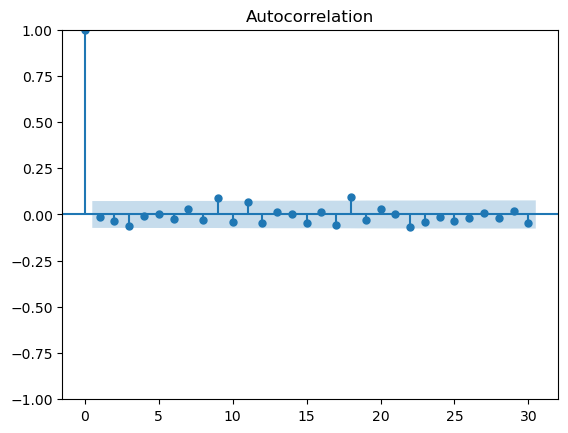

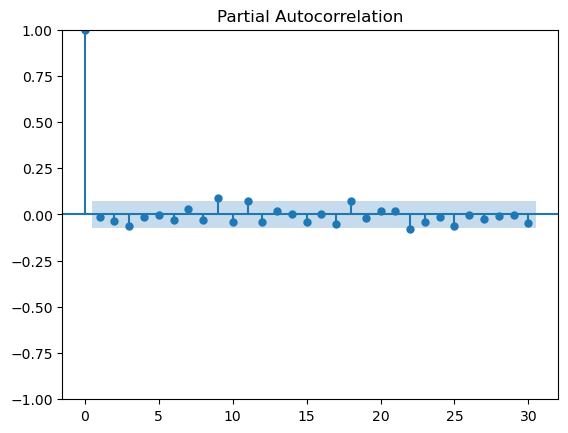

In [7]:
# Check autocorrelation at maxlag = 30
plt.figure()
plot_acf(data[['return']].astype(float),lags = 30)
plot_pacf(data[['return']].astype(float),lags = 30)
plt.show()

We can see there is no significant spikes or declining trend. By intuition, we'd better not use ARMA model to describe the process.

The *Ljung-Box* test is defined as:
- $H_0$: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
- $H_A$: The data are not independently distributed; they exhibit serial correlation.
The test statistic(the lb_stat below):
$$
Q = n(n+2)\sum_{k=1}^h\frac{\hat{\rho}_k^2}{n-k}
$$
where $n$ is the sample size, $\hat{\rho}_k$ is the sample autocorrelation at lag k, and h is the number of lags being tested. Under $H_{0}$ the statistic Q asymptotically follows a $\chi_{h}^2$. For a significance level $\alpha$, we can find the critical region for rejection of the hypothesis of randomness is:
$$
Q\geq\chi_{1-\alpha,h}^2
$$
where $\chi_{1-\alpha,h}^2$ is the $(1-\alpha)$-quantile of the chi-squared distribution with h degrees of freedom.

In [8]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(data[['return']], lags=10, return_df=True)

,lb_stat,lb_pvalue
1,0.127491,0.721047
2,0.996837,0.607491
3,3.808092,0.282946
4,3.878207,0.422740
5,3.891626,0.565122
6,4.381086,0.625251
7,5.024466,0.656977
8,5.731373,0.677293
9,11.802541,0.224671
10,13.095748,0.218368


In [9]:
from scipy.stats import chi2
cv5 = chi2.ppf(0.95,5)
cv10 = chi2.ppf(0.95,10)
cv5,cv10

(11.070497693516351, 18.307038053275146)

Here we can directly use pvalue to check it.
$$0.05 < 0.218,\quad 0.05 < 0.565125$$
or we check it based on the Q(5), Q(10) and their critical values under lag = 5, 10.
$$Q(5) = 3.891606 < 11.070498,\quad Q(10) = 13.095911 < 18.3070381$$
So we can see there is no presence of autocorrelations in this time series.

## Problem 3

To check if the process is stationary, we can use its characteristic polynomial. Consider the equation as below:
$$
\psi(z) = 1 + 1.1z - 0.18z^2 = 0
$$

In [10]:
import sympy as sp
z = sp.symbols("z")
z1, z2 = sp.solve("1+1.1*z-0.18*z**2",z)
z1, z2

(-0.803456663736057, 6.91456777484717)

We can see the first unit root is outside the unit circle:
$$||z_1|| = 0.803457 < 1$$
which shows the process is not covariance stationary.

## Problem 4

Use the same approach as Problem 3, we obtain the characteristic polynomial of the $AR(2)$ process:
$$
\psi(z) = 1 - \beta_1 z - \beta_2^2 z^2 = 0
$$
To help us discuss the cases, substitute $w = \frac{1}{z}$, we obtain:
$$
w^2 - \beta_1 w - \beta_2 = 0
$$
We need to make sure the unit root $||z|| > 1$ outside the unit circle. Namely, we have $||w|| = \frac{1}{|z|} < 1$.

For this quadratic equation, we know the root is:
$$
w_{1,2} = \frac{\beta_1 \pm \sqrt{\beta_1^2+4\beta_2}}{2}
$$
Then we have two cases.

#### Real roots
When $\beta_1^2+4\beta_2 \geq 0$, the solutions are real roots.

For real roots, we just check the absolute value:
$$
\left|\frac{\beta_1 \pm \sqrt{\beta_1^2+4\beta_2}}{2}\right| < 1\Rightarrow -1 < \frac{\beta_1 -\sqrt{\beta_1^2+4\beta_2}}{2} \leq \frac{\beta_1 + \sqrt{\beta_1^2+4\beta_2}}{2} < 1
$$
For the upper bound, we have:
$$
\frac{\beta_1 + \sqrt{\beta_1^2+4\beta_2}}{2} < 1\Rightarrow \beta_1 + \sqrt{\beta_1^2+4\beta_2} < 2 \Rightarrow \beta_1^2+4\beta_2 < (2-\beta_1)^2\Rightarrow \beta_1+\beta_2 < 1
$$
For the lower bound, we have:
$$
-1 < \frac{\beta_1 - \sqrt{\beta_1^2+4\beta_2}}{2} \Rightarrow -2 < \beta_1 - \sqrt{\beta_1^2+4\beta_2} \Rightarrow \beta_1^2+4\beta_2 < (2+\beta_1)^2\Rightarrow \beta_2-\beta_1 < 1
$$
So we have the conditions: $\beta_1+\beta_2 < 1$ and $\beta_2 - \beta_1 < 1$ when $\beta_1^2+4\beta_2 \geq 0$.

#### Complex roots
When $\beta_1^2+4\beta_2 < 0$, the solutions are complex roots.

We have the solutions:
$$
w_{1,2} = \frac{\beta_1}{2} \pm \frac{\sqrt{-4\beta_2-\beta_1^2}}{2}i
$$
They have the same norm
$$
||w_1|| = ||w_2|| = \left(\frac{\beta_1}{2}\right)^2 + \left(\frac{\sqrt{-4\beta_2-\beta_1^2}}{2}\right)^2 = \frac{\beta_1^2}{4} - \frac{4\beta_2+\beta_1^2}{4} = -\beta_2 < 1
$$
So we have the condition: $\beta_2 > -1$ when $\beta_1^2+4\beta_2 < 0$.

In conclusion, we obtain the conditions for *AR(2)* process:
- <font color=red>$\beta_1+\beta_2 < 1$</font>
- <font color=blue>$\beta_2-\beta_1 < 1$</font>
- $\beta_2 > -1$, combined with the two conditions above, it can be shown as <font color=green>$|\beta_2| < 1$</font>.

The region can be shown as the triangle constructed by the three colored lines, the colors correspond to the conditions above. And the <font color=magenta>curve</font> is the condition of real/complex roots.
<img src="./condition.png" width="600" />